In [1]:
import random

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/Users/liang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
Unnamed: 0    10000 non-null int64
default       10000 non-null object
student       10000 non-null object
balance       10000 non-null float64
income        10000 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.7+ KB


In [4]:
df.describe()

,Unnamed: 0,balance,income
count,10000.00000,10000.000000,10000.000000
mean,5000.50000,835.374886,33516.981876
std,2886.89568,483.714985,13336.639563
min,1.00000,0.000000,771.967729
25%,2500.75000,481.731105,21340.462903
50%,5000.50000,823.636973,34552.644802
75%,7500.25000,1166.308386,43807.729272
max,10000.00000,2654.322576,73554.233495


In [5]:
df.default.value_counts()

No     9667
Yes     333
Name: default, dtype: int64

In [6]:
df.student.value_counts()

No     7056
Yes    2944
Name: student, dtype: int64

In [7]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

2) Convert `default` and `student` to categorical variables.

In [8]:
df.default = df.default.map({'No': 0, "Yes": 1})
df.student = df.student.map({'No': 0, "Yes": 1})

In [9]:
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

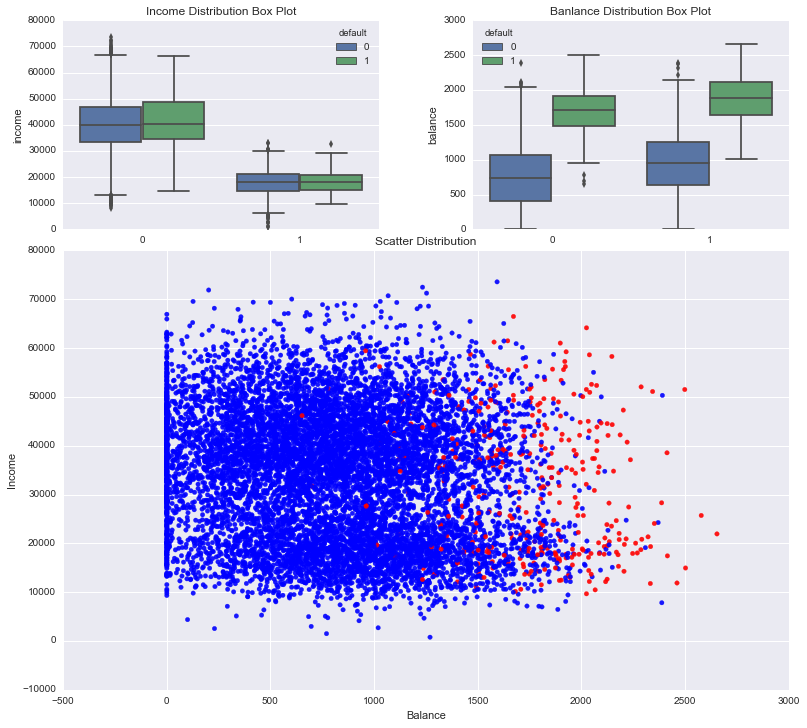

In [10]:
plt.figure(figsize=(13, 12))
grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.1)

color = {0: 'blue', 1: 'red'}

plt.subplot(grid[0, 0])
sns.boxplot(x="student", y="income", hue="default", data=df)
plt.title('Income Distribution Box Plot')

plt.subplot(grid[0, 1])
sns.boxplot(x="student", y="balance", hue="default", data=df)
plt.title('Banlance Distribution Box Plot')

plt.subplot(grid[1:, :])
plt.scatter(df.balance, df.income, color=df['default'].apply(lambda x: color[x]), s=20, alpha=.9)
plt.title('Scatter Distribution')
plt.xlabel('Balance')
plt.ylabel('Income')

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

======score matirx============
[[ 0.8974359   0.82905983  0.88034188  0.83760684]
 [ 0.86324786  0.79487179  0.86324786  0.8974359 ]
 [ 0.84615385  0.88888889  0.84615385  0.83760684]
 [ 0.94017094  0.85470085  0.88888889  0.82051282]]
======auc matrix==============
[[ 0.96183432  0.93816568  0.92633136  0.93343195]
 [ 0.94230769  0.93757396  0.94142012  0.95798817]
 [ 0.93047337  0.96775148  0.92840237  0.94171598]
 [ 0.97899408  0.94792899  0.94201183  0.89970414]]


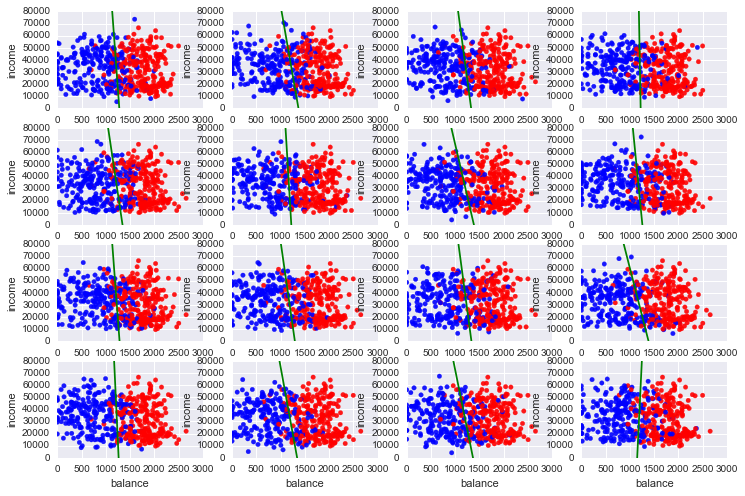

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

from sklearn import metrics


use_col = ['balance', 'income']
predict_col = ['default']


def choose_sample(df, proportion=0.7):
    minor_count = df[df.default == 1].shape[0]
    sample_size = int(proportion*minor_count)
    
    good_df = df[df.default == 0][use_col+predict_col].values
    bad_df = df[df.default == 1][use_col+predict_col].values
    
    good_sample = np.array(random.sample(list(good_df), sample_size))
    bad_sample = np.array(random.sample(list(bad_df), sample_size))
    train_sample = np.vstack((good_sample, bad_sample))
        
    X, y = train_sample[:, :2], train_sample[:, 2]
    random_state = np.random.RandomState(0)
    X, y = shuffle(X, y, random_state=random_state)
    
    return X, y


def calc_auc(y, scores):
    fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)   
    return fpr, tpr, metrics.auc(fpr, tpr)


fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axes = axes.flatten()

scores = []
aucs = []
models = []
fprs = []
tprs = []

for ax in axes:
    X, y = choose_sample(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    lr = LogisticRegression(penalty='l1', class_weight={0: 1, 1: 2})
    lr.fit(X_train, y_train)
    
    fpr, tpr, auc = calc_auc(y_test, lr.predict_proba(X_test)[:, 1])

    scores.append(lr.score(X_test, y_test))
    aucs.append(auc)
    models.append(lr)
    fprs.append(fpr)
    tprs.append(tpr)

    w0 = lr.intercept_[0]
    w1, w2= lr.coef_[0]

    line_x = np.linspace(0, 2500, 100)
    line_y = (-w0 - w1*line_x) / w2
             
    ax.scatter(X[:, 0], X[:, 1], color=list(map(lambda x: color[x], y)), s=20, alpha=.9)
    ax.set(xlim=(0, 3000), ylim=(0, 80000),
       xlabel="balance", ylabel="income")
    ax.plot(line_x, line_y, 'g-')
    
print('======score matirx============')
print(np.array(scores).reshape(4, 4))
print('======auc matrix==============')
print(np.array(aucs).reshape(4, 4))

In [12]:
def plt_top_n_roc_curve(idxs):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'g')
    
    for idx in idxs:
        fpr = fprs[idx]
        tpr = tprs[idx]
        plt.plot(fpr, tpr)
    
    plt.xlabel('FPR')
    plt.ylabel("TPR")
    plt.title('Receiver Operating Characteristic Curve')

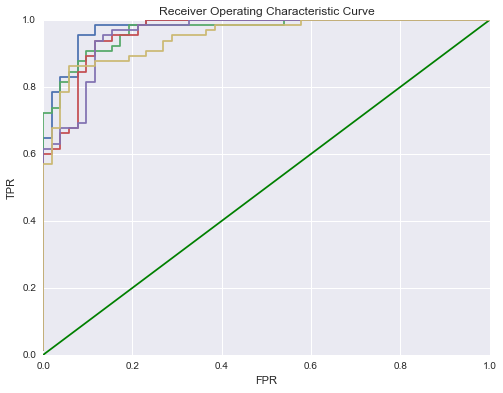

In [13]:
top5_idx = np.argsort(np.array(aucs))[::-1][:5]
plt_top_n_roc_curve(top5_idx)

current model auc: 0.95


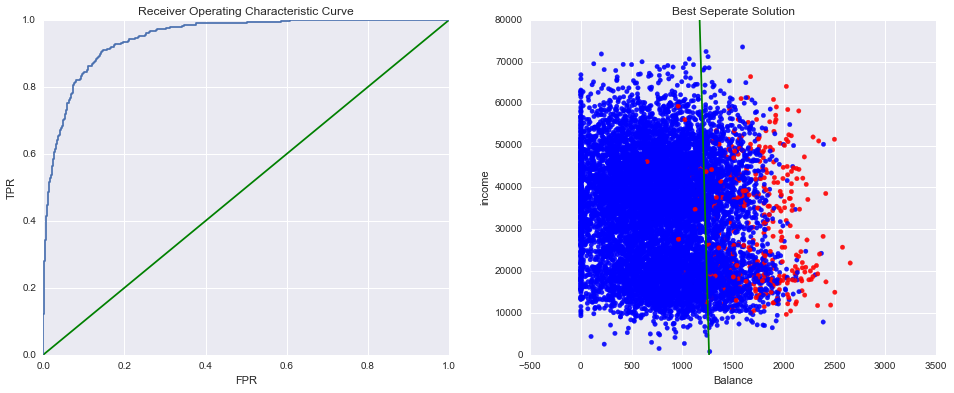

In [14]:
top_model = models[top5_idx[0]]

X = df[use_col].values
y = df[predict_col].values

fpr, tpr, auc = calc_auc(y, top_model.predict_proba(X)[:, 1])

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'g')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic Curve')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], color=list(map(lambda x: color[x], y[:, 0])), s=20, alpha=.9)

w0 = top_model.intercept_[0]
w1, w2= top_model.coef_[0]
line_x = np.linspace(0, 3000, 100)
line_y = (-w0 - w1*line_x) / w2
plt.plot(line_x, line_y, 'g')
plt.ylim(0, 80000)
plt.xlabel('Balance')
plt.ylabel('income')
plt.title('Best Seperate Solution')

print('current model auc: %.2f' % auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [15]:
use_col = ['balance', 'income', 'student']

def choose_sample(df, proportion=0.7):
    minor_count = df[df.default == 1].shape[0]
    sample_size = int(proportion*minor_count)
    
    good_df = df[df.default == 0][use_col+predict_col].values
    bad_df = df[df.default == 1][use_col+predict_col].values
    
    good_sample = np.array(random.sample(list(good_df), sample_size))
    bad_sample = np.array(random.sample(list(bad_df), sample_size))
    train_sample = np.vstack((good_sample, bad_sample))
        
    X, y = train_sample[:, :3], train_sample[:, 3]
    random_state = np.random.RandomState(0)
    X, y = shuffle(X, y, random_state=random_state)
    
    return X, y


X, y = choose_sample(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lr = LogisticRegression(penalty='l2', class_weight={0: 1, 1: 2})
lr.fit(X, y)

fpr, tpr, auc = calc_auc(y, lr.predict_proba(X)[:, 1])

In [16]:
pd.DataFrame({'coef': lr.coef_[0], 'column': use_col}).sort_values(by='coef', ascending=False)

,coef,column
0,0.002139,balance
2,-0.000003,student
1,-0.000054,income


current model auc: 0.86


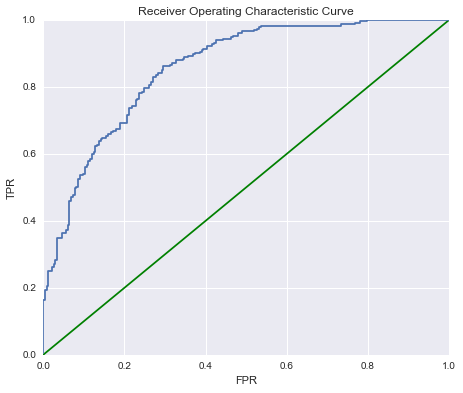

In [17]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'g')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic Curve')

print('current model auc: %.2f' % auc)

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [18]:
from sklearn.model_selection import cross_val_score


def scorer(model, x, y):
    md = model.fit(x, y)
    prob = md.predict_proba(x)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y, prob, pos_label=1)
    return metrics.auc(fpr, tpr)
    
X, y = choose_sample(df)

scores = cross_val_score(lr, X, y, cv=5, scoring=scorer)
print("mean AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

mean AUC: 0.86 (+/- 0.07)


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [19]:
X_all = df[use_col].values
y_all = df[predict_col].values[:, 0]

In [20]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(max_depth=5)
scores = cross_val_score(dt, X_all, y_all, cv=5, scoring=scorer)
print("mean AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

mean AUC: 0.97 (+/- 0.02)


In [21]:
for depth in range(1, 10):
    dt = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(dt, X_all, y_all, cv=5, scoring=scorer)
    print("depth: %d mean AUC: %0.2f (+/- %0.2f)" % (depth, scores.mean(), scores.std() * 2))

depth: 1 mean AUC: 0.73 (+/- 0.08)
depth: 2 mean AUC: 0.88 (+/- 0.08)
depth: 3 mean AUC: 0.94 (+/- 0.04)
depth: 4 mean AUC: 0.96 (+/- 0.02)
depth: 5 mean AUC: 0.97 (+/- 0.02)
depth: 6 mean AUC: 0.98 (+/- 0.01)
depth: 7 mean AUC: 0.99 (+/- 0.01)
depth: 8 mean AUC: 0.99 (+/- 0.01)
depth: 9 mean AUC: 1.00 (+/- 0.01)


8) Find the optimal decision tree depth and compute the AUC ROC. 

current model auc: 0.98


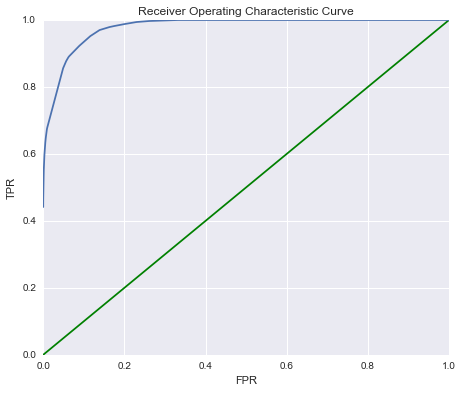

In [22]:
dt = DecisionTreeClassifier(max_depth=9)

dt.fit(X_all, y_all)
fpr, tpr, auc = calc_auc(y_all, dt.predict_proba(X_all)[:, 1])

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'g')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic Curve')

print('current model auc: %.2f' % auc)